![Logo](../assets/logo.png)

Made by **Domonkos Nagy**

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/4.%20Monte%20Carlo/blackjack_solution.ipynb)

# Blackjack (solution)

Blackjack is a card game where the goal is to beat the dealer by obtaining cards that sum to closer to 21 (without going over 21) than the dealers cards.
The game starts with the dealer having one face up and one face down card, while the player has two face up cards. All cards are drawn from an infinite deck (i.e. with replacement).

<img src="assets/blackjack.gif" width="500"/>

The card values are:

- Face cards (Jack, Queen, King) have a point value of 10.
- Aces can either count as 11 (called a ‘usable ace’) or 1.
- Numerical cards (2-9) have a value equal to their number.

The player has the sum of cards held. The player can request additional cards (*hit*) until they decide to stop (*stick*) or exceed 21 (*bust*, immediate loss).
After the player sticks, the dealer reveals their facedown card, and draws cards until their sum is 17 or greater. If the dealer goes bust, the player wins.
If neither the player nor the dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21. If the player has 21 immediately (an ace and a 10-card),
it is called a *natural*. The player then wins unless the dealer also has a natural, in which case the game is a draw.

We are going to use the `Blackjack-v1` environment of the `Gymnasium` library. The states are 3-component tuples, where the components are:

1. The player's current sum (0 - 31)
2. The dealer's face up card (1 - 10, where 1 is Ace)
3. Whether the player has a usable ace (0 for no, 1 for yes)

An action is either 0 (stick) or 1 (hit). The reward is +1 for winning the game, -1 for losing, and 0 for a draw.

This example uses an *Off-policy Monte Carlo* algorithm to approximate the optimal policy.

- This notebook is based on Chapter 5 of the book *Reinforcement Learning: An Introduction (2nd ed.)* by R. Sutton & A. Barto, available at http://incompleteideas.net/book/the-book-2nd.html
- Documentation for the Blackjack environment: https://gymnasium.farama.org/environments/toy_text/blackjack/

In [1]:
# Install dependencies if running in Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install gymnasium==0.29.0

In [2]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.notebook import trange
from matplotlib.patches import Patch
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.print_figure_kwargs = {'pad_inches': .3}

In [3]:
# Hyperparameters
N_EPISODES = 1_000_000  # Number of training episodes
EPSILON_MAX = 1  # Initial exploration
EPSILON_MIN = 0.1  # Final exploration
EPSILON_DECAY = 2 * EPSILON_MAX / N_EPISODES  # Exploration decay rate
GAMMA = 0.99  # Discount factor
N_RECORDINGS = 3  # Number of episodes to record
REC_EPISODES = np.linspace(0, N_EPISODES-1, num=N_RECORDINGS, dtype=int)  # Episodes to record
LOG_FREQ = N_EPISODES / 10  # Progress log frequency

In [4]:
# Create environment
base_env = gym.make('Blackjack-v1', sab=True, render_mode='rgb_array')  # 'sab' for Sutton & Barto's version
# Wrap environment to record videos throughout the learning process 
trigger = lambda ep: ep in REC_EPISODES
env = RecordVideo(base_env, video_folder="./videos", episode_trigger=trigger, disable_logger=True)

In [5]:
action_space_size = env.action_space.n
observation_space_shape = tuple([dim.n for dim in env.observation_space])
q_table_shape = observation_space_shape + (action_space_size, )

# Create Q-table and weight matrix
q_table = np.zeros(q_table_shape)
weights = np.zeros(q_table_shape)

## Off-policy Monte Carlo Control

*Monte Carlo* (MC) methods are iterative processes for finding the optimal policy and state-value function, similarly to Value Iteration. However, instead
of doing sweeps of the complete state set, MC algorithms only simulate episodes. *Off-policy* means that the policy used to simulate episodes (*behaviour policy*) is different
from the policy learned (*target policy*): in this case, the target policy is a deterministic policy $\pi$, while the behaviour policy $b$ is an $\varepsilon$-greedy policy, that
uses $\pi$'s state-value function to determine the best action for each state.

Let's consider the *On-policy* version of this method first, that is, where the policy used to generate the episodes, $b$ is identical to the policy being evaulated, $\pi$. We simulate an episode using the policy, and save the resulting trajectory: $S_0, A_0, R_1, S_1, A_1, ..., S_{T-1}, A_{T-1}, R_T$ ($T$ is the terminal time step).
Looping backwards through the trajectory, we calculate the returns for each step, and update our value function so that the value of each state-action pair will be the
average of the returns observed after visiting that state and taking that action. After that, we update the policy according to the new action-value function. As long as the policy is $\varepsilon$-greedy, this method will converge to the best $\varepsilon$-soft policy (a policy is $\varepsilon$-soft if $\pi(a|s) > \frac{\varepsilon}{|\mathcal{A}(S_t)|}$ for all $a, s$).

In contrast, the Off-policy method uses different behaviour and target policies. In this case, when updating the action-value function, we have to take into account
the difference between $\pi(a|s)$ and $b(a|s)$, since we use data generated by using $b$ to better estimate the action-value function of $\pi$. We can account for this difference
by calculating the *importance-sampling ratio*:

$$ \rho_{t:T-1} := \prod_{k=t}^{T-1} \frac{\pi(A_k|S_k)}{b(A_k|S_k)} $$

The state-action value is then determined by the weighted average of all previous returns:

$$ Q(s,a) := \frac{\sum_{t\in\mathcal{T}(s,a)} \rho_{t:T(t)-1} G_t}{\sum_{t\in\mathcal{T}(s,a)} \rho_{t:T(t)-1}} $$

Where $T(t)$ is the terminal time step of the episode where $t$ is sampled from, and $\mathcal{T}(s,a)$ denotes the set of all time steps where action $a$ was selected in state $s$ (in any episode).

Weighing the returns with the importance-sampling ratio lets us update the action-value function of $\pi$ using only data generated with $b$. Using this method we are not limited
to just $\varepsilon$-soft methods: while the behaviour policy is more exploratory, the target policy can be deterministic.

***

### **Your Task**

Implement this algorithm! The block below only contains code necessary for logging the average reward at every `LOG_FREQ` iterations. The algorithm itself is up to you! Pseudocode for this algorithm is shown in the box below.

<img src="assets/monte_carlo.png" width="700"/>

*Pseudocode from page 111 of the Sutton & Barto book*

#### **Hints:**

- This pseudocode updates the $Q$-values (weighted averages) incrementally, similarly to the method described in the $k$-armed bandit chapter.
- It is recommended to use an $\varepsilon$-greedy policy as $b$.
- Use the arrays defined above: `q_table` corresponds to $Q$, and `weights` corresponds to $C$ in the pseudocode.
- When recording a trajectory, in addition to the state-action-reward sequence, you should store $b(A_t|S_t)$ at each step as well.
- Since we need the tie-breaking of argmax to be consistent, it is better to use `np.argmax` this time instead of the `argmax` we defined in an earlier notebook.

***

In [6]:
# Re-intialize environment, weights and Q-table
env = RecordVideo(base_env, video_folder="./videos", episode_trigger=trigger, disable_logger=True)
q_table = np.zeros(q_table_shape)
weights = np.zeros(q_table_shape)
sum_rewards = 0
epsilon = EPSILON_MAX

# Training loop
for episode in trange(N_EPISODES):

    # Set up variables
    obs, _ = env.reset()
    done = False
    trajectory = []
    returns = 0
    weight = 1

    # Simulate episodes
    while not done:
        best_action = np.argmax(q_table[obs])

        # Epsilon-greedy action selection
        if np.random.rand() > epsilon:
            action = best_action
        else:
            action = env.action_space.sample()
                
        prob_choice = 1 - (epsilon / 2) if action == best_action else epsilon / 2  # Probability of choosing this action under the behaviour policy
        new_obs, reward, terminated, truncated, info = env.step(action)  # Take step
        done = terminated or truncated
        trajectory.append((obs, action, reward, prob_choice))  # Add to trajectory

        # Store reward and new state
        sum_rewards += reward
        obs = new_obs

    trajectory.reverse()  # Reverse trajectory to loop back from the end

    # Loop back in trajectory
    for step in trajectory:
        obs, action, reward, prob_choice = step
        returns = reward + GAMMA * returns  # Update returns

        # Update Q-table
        idx = obs + (action, )
        weights[idx] += weight
        q_table[idx] += (weight / weights[idx]) * (returns - q_table[idx])

        # Since the target policy is deterministic,
        # this means that the importance-sampling ratio is 0
        if action != np.argmax(q_table[obs]):
            break

        # Update weight
        weight /= prob_choice

    # Decay epsilon
    epsilon = max(epsilon - EPSILON_DECAY, EPSILON_MIN)

    # Log results
    if (episode + 1) % LOG_FREQ == 0:
        print(f'Episode {episode + 1} : avg={sum_rewards / LOG_FREQ}')
        sum_rewards = 0

# Save Q-table
with open('q_table.bin', 'wb') as f:
    pickle.dump(q_table, f)

# Close environment
env.close()

  0%|          | 0/4000000 [00:00<?, ?it/s]

Episode 400000 : avg=-0.3595975
Episode 800000 : avg=-0.2898025
Episode 1200000 : avg=-0.220615
Episode 1600000 : avg=-0.1522275
Episode 2000000 : avg=-0.0894475
Episode 2400000 : avg=-0.0793025
Episode 2800000 : avg=-0.0783425
Episode 3200000 : avg=-0.0787125
Episode 3600000 : avg=-0.078945
Episode 4000000 : avg=-0.0799


## Final Value Function and Policy

The plots for the final state-value function and policy are shown below. The player sum below 12 (or above 21) is irrelevant, so it is not shown here:
in the with-usable-ace case, a sum less than 12 is not even possible, and in the no-usable-ace case, hitting is trivially better than sticking.

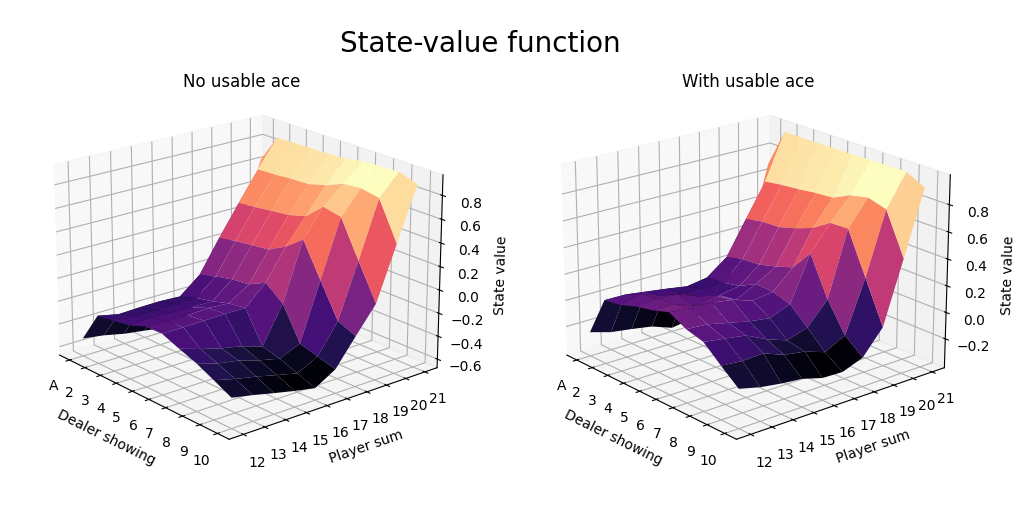

In [7]:
# Get value functions
state_value_no_usable_ace = np.max(q_table[12:22, 1:, 0, :], axis=-1)
state_value_with_usable_ace = np.max(q_table[12:22, 1:, 1, :], axis=-1)

x_tick_labels = ['A'] + list(range(2, 11))  # 'Ace' instead of 1

x, y = np.meshgrid(np.arange(state_value_no_usable_ace.shape[0]),
                   np.arange(state_value_no_usable_ace.shape[1]))

fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
ax1, ax2 = axs

# Options for both plots
plt.setp(axs, xticks=np.arange(10),
         xticklabels=x_tick_labels,
         yticks=np.arange(10), yticklabels=np.arange(12, 22),
         xlabel='Dealer showing', ylabel='Player sum', zlabel='State value')

# 'No usable ace' plot
ax1.plot_surface(x, y, state_value_no_usable_ace, cmap='magma')
ax1.view_init(20, -40)
ax1.set_title('No usable ace', y=1)

# 'With usable ace' plot
ax2.plot_surface(x, y, state_value_with_usable_ace, cmap='magma')
ax2.view_init(20, -40)
ax2.set_title('With usable ace', y=1)

fig.suptitle('State-value function', fontsize=20, y=0.9)
plt.show()

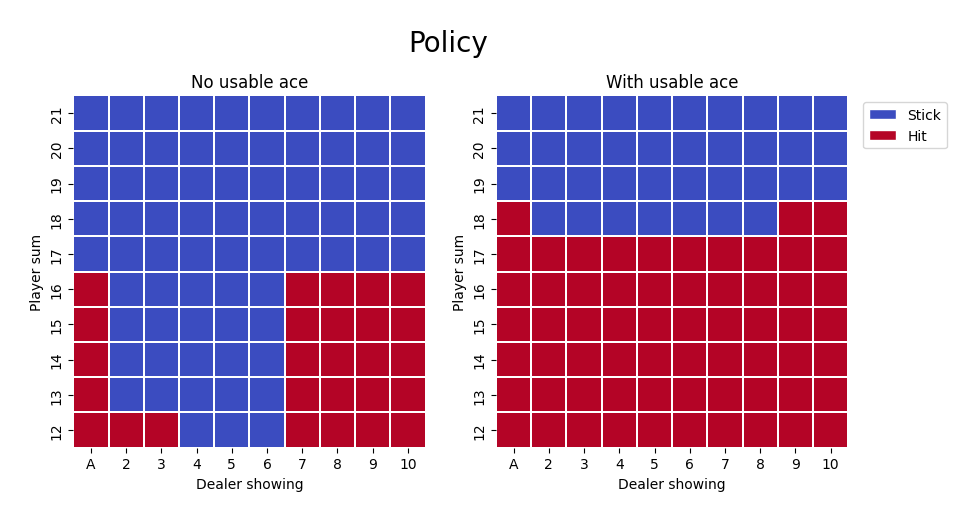

In [8]:
# Get policies
policy_no_usable_aces = np.argmax(q_table[12:22, 1:, 0, :], axis=-1)
policy_with_usable_aces = np.argmax(q_table[12:22, 1:, 1, :], axis=-1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axs

# 'No usable ace' plot
sns.heatmap(np.flip(policy_no_usable_aces, axis=0), cmap='coolwarm',
            linecolor='white', linewidths=0.05, square=True,
            yticklabels=np.arange(21, 11, -1),
            xticklabels=x_tick_labels,
            cbar=False, ax=ax1)
ax1.set_title('No usable ace')

# 'With usable ace' plot
sns.heatmap(np.flip(policy_with_usable_aces, axis=0), cmap='coolwarm',
            linecolor='white', linewidths=0.05, square=True,
            yticklabels=np.arange(21, 11, -1),
            xticklabels=x_tick_labels,
            cbar=False, ax=ax2)
ax2.set_title('With usable ace')

# Options for both plots
plt.setp(axs, xlabel='Dealer showing', ylabel='Player sum')

legend_elements = [
        Patch(facecolor="#3b4cc0", edgecolor="white", label="Stick"),
        Patch(facecolor="#b50526", edgecolor="white", label="Hit"),
    ]

fig.suptitle('Policy', fontsize=20)
plt.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
plt.show()

## Results

You can watch the videos recorded throughout the training process here:

In [9]:
# Display recordings
children = [widgets.Video.from_file(f'./videos/rl-video-episode-{episode}.mp4', autoplay=False, loop=False, width=500) for episode in REC_EPISODES]
tab = widgets.Tab()
tab.children = children
titles = tuple([f'Episode {episode + 1:,}' for episode in REC_EPISODES])
for i in range(len(children)):
    tab.set_title(i, titles[i])
display(tab)